In [3]:
!earthengine-authenticate

/bin/bash: line 1: earthengine-authenticate: command not found


In [1]:
pip install earthengine-api

In [31]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt



In [7]:
ee.Authenticate()

ee.Initialize(project='data-centaur-452217-j1')

In [11]:
# Load Country Boundaries
country = (ee.FeatureCollection('FAO/GAUL/2015/level0')
           .filter(ee.Filter.eq('ADM0_NAME', 'Chad')))

In [13]:
# Load satellite data
satellite = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
             .filterDate('2023-01-01', '2023-12-31')  # Adjust dates as needed
             .filterBounds(country)
             .median())

In [15]:
# Mask satellite data to country
masked_satellite = satellite.clip(country)

In [18]:
# Create an interactive map
Map = geemap.Map()

In [19]:
# Add layers to the map
Map.addLayer(country, {}, 'Country Boundary')
Map.addLayer(masked_satellite, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, 'Satellite Image')

In [20]:
# Center the map on your country
Map.centerObject(country, 5)

In [24]:
# Display map
Map

Map(bottom=2108.0, center=[20.632784250388028, 14.853515625000002], controls=(WidgetControl(options=['position…

In [41]:
# Load Chad's geometry
chad = (ee.FeatureCollection('FAO/GAUL/2015/level0')
        .filter(ee.Filter.eq('ADM0_NAME', 'Chad')))

# Crop calendar for millet (June to October)
start_month = 6  # June
end_month = 10   # October
years = range(1993, 2023)  # Last 30 years

In [56]:
srtm = ee.Image('USGS/SRTMGL1_003')  # Elevation
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')  # Precipitation
modis_lst = ee.ImageCollection('MODIS/006/MOD11A2')  # Temperature
modis_et = ee.ImageCollection('MODIS/006/MOD16A2')  # Evapotranspiration

def get_climatic_data(year):
    start_date = f'{year}-{start_month:02d}-01'
    end_date = f'{year}-{end_month:02d}-31'

    # Elevation (static, always available)
    elevation = srtm.select('elevation').reduceRegion(
        reducer=ee.Reducer.mean(), geometry=chad, scale=1000)

    # Precipitation (CHIRPS starts 1981, always available)
    precip = (chirps.filterDate(start_date, end_date)
              .sum()
              .reduceRegion(reducer=ee.Reducer.mean(), geometry=chad, scale=5000))

    # Temperature (MODIS LST starts 2000)
    lst_collection = modis_lst.filterDate(start_date, end_date).select('LST_Day_1km')
    if lst_collection.size().getInfo() > 0:
        temp = (lst_collection.mean()
                .multiply(0.02).subtract(273.15)
                .reduceRegion(reducer=ee.Reducer.mean(), geometry=chad, scale=1000))
    else:
        temp = {'LST_Day_1km': None}
        print(f"No MODIS LST data for {year}")

    # Evapotranspiration (MODIS ET starts 2000)
    et_collection = modis_et.filterDate(start_date, end_date).select('ET')
    if et_collection.size().getInfo() > 0:
        et = (et_collection.sum()
              .reduceRegion(reducer=ee.Reducer.mean(), geometry=chad, scale=500))
    else:
        et = {'ET': None}
        print(f"No MODIS ET data for {year}")

    return {'elevation': elevation, 'precip': precip, 'temp': temp, 'et': et}

# Test
data = get_climatic_data(2023)
print(data['precip'].getInfo())

No MODIS LST data for 2023
No MODIS ET data for 2023
{'precipitation': 302.2244939262094}


In [57]:
smap = ee.ImageCollection('NASA/SMAP/SPL4SMGP/007')
modis_vi = ee.ImageCollection('MODIS/006/MOD13A2')

def get_agricultural_data(year):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    if year >= 2015:
        soil_moisture = (smap.filterDate(start_date, end_date)
                         .select('sm_surface')
                         .mean()
                         .reduceRegion(reducer=ee.Reducer.mean(), geometry=chad, scale=10000))
    else:
        soil_moisture = {'sm_surface': None}
    vi_collection = (modis_vi.filterDate(start_date, end_date)
                     .select(['NDVI', 'EVI'])
                     .filterBounds(chad))
    vi_count = vi_collection.size().getInfo()
    print(f"Year {year}: {vi_count} MODIS VI images found")
    if vi_count > 0:
        dates = vi_collection.aggregate_array('system:time_start').getInfo()
        print(f"Dates: {[pd.Timestamp(d, unit='ms').strftime('%Y-%m-%d') for d in dates]}")
        vi = vi_collection.mean().reduceRegion(
            reducer=ee.Reducer.mean(), geometry=chad, scale=1000)
        vi_dict = vi.getInfo()
        ndvi = vi_dict.get('NDVI', None)
        evi = vi_dict.get('EVI', None)
    else:
        ndvi = None
        evi = None
        print(f"No MODIS VI data available for {year}")
    return {'soil_moisture': soil_moisture, 'ndvi': ndvi, 'evi': evi}

# Test
ag_data = get_agricultural_data(2023)
print("NDVI:", ag_data['ndvi'] if ag_data['ndvi'] is not None else "None")
print("EVI:", ag_data['evi'] if ag_data['evi'] is not None else "None")

Year 2023: 3 MODIS VI images found
Dates: ['2023-01-01', '2023-01-17', '2023-02-02']
NDVI: 1816.0533243677908
EVI: 1189.6889421269573


No MODIS LST data for 1993
No MODIS ET data for 1993
Year 1993: 0 MODIS VI images found
No MODIS VI data available for 1993
No MODIS LST data for 1994
No MODIS ET data for 1994
Year 1994: 0 MODIS VI images found
No MODIS VI data available for 1994
No MODIS LST data for 1995
No MODIS ET data for 1995
Year 1995: 0 MODIS VI images found
No MODIS VI data available for 1995
No MODIS LST data for 1996
No MODIS ET data for 1996
Year 1996: 0 MODIS VI images found
No MODIS VI data available for 1996
No MODIS LST data for 1997
No MODIS ET data for 1997
Year 1997: 0 MODIS VI images found
No MODIS VI data available for 1997
No MODIS LST data for 1998
No MODIS ET data for 1998
Year 1998: 0 MODIS VI images found
No MODIS VI data available for 1998
No MODIS LST data for 1999
No MODIS ET data for 1999
Year 1999: 0 MODIS VI images found
No MODIS VI data available for 1999
No MODIS ET data for 2000
Year 2000: 20 MODIS VI images found
Dates: ['2000-02-18', '2000-03-05', '2000-03-21', '2000-04-06', '2000-

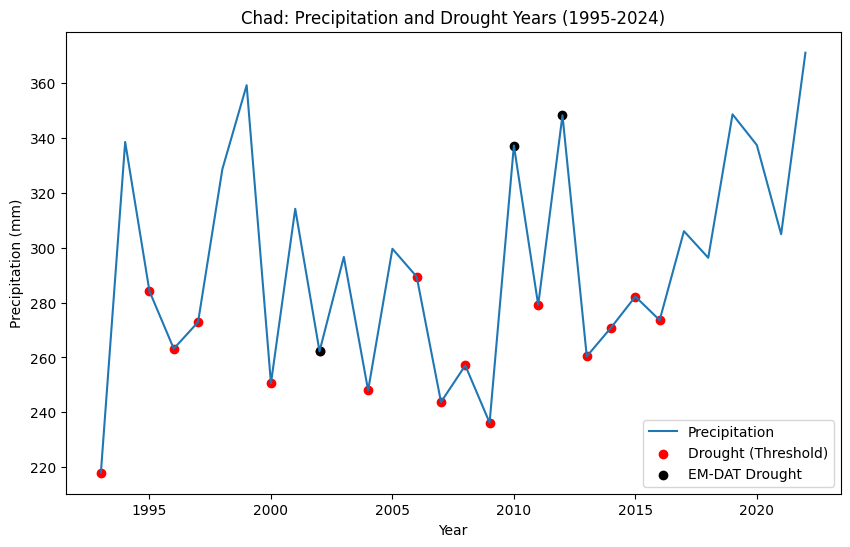

Map(center=[15.282206186229162, 18.65135847264551], controls=(WidgetControl(options=['position', 'transparent_…

In [58]:
chad_data = []
for year in years:
    climatic = get_climatic_data(year)
    ag = get_agricultural_data(year)
    chad_data.append({
        'year': year,
        'elevation': climatic['elevation'].get('elevation').getInfo(),
        'precip': climatic['precip'].get('precipitation').getInfo(),
        'temp': climatic['temp'].get('LST_Day_1km').getInfo() if climatic['temp'].get('LST_Day_1km') is not None else None,
        'et': climatic['et'].get('ET').getInfo() if climatic['et'].get('ET') is not None else None,
        'soil_moisture': ag['soil_moisture'].get('sm_surface') if ag['soil_moisture'] else None,
        'ndvi': ag['ndvi'],
        'evi': ag['evi'],
    })

chad_df = pd.DataFrame(chad_data)
precip_avg = chad_df['precip'].mean()
chad_df['drought'] = chad_df['precip'] < precip_avg
emdat_droughts = [2002, 2010, 2012]
chad_df['emdat_drought'] = chad_df['year'].isin(emdat_droughts)

print("\nChad Drought Comparison (1995-2024):")
print(chad_df[['year', 'precip', 'ndvi', 'drought', 'emdat_drought']].head(10))


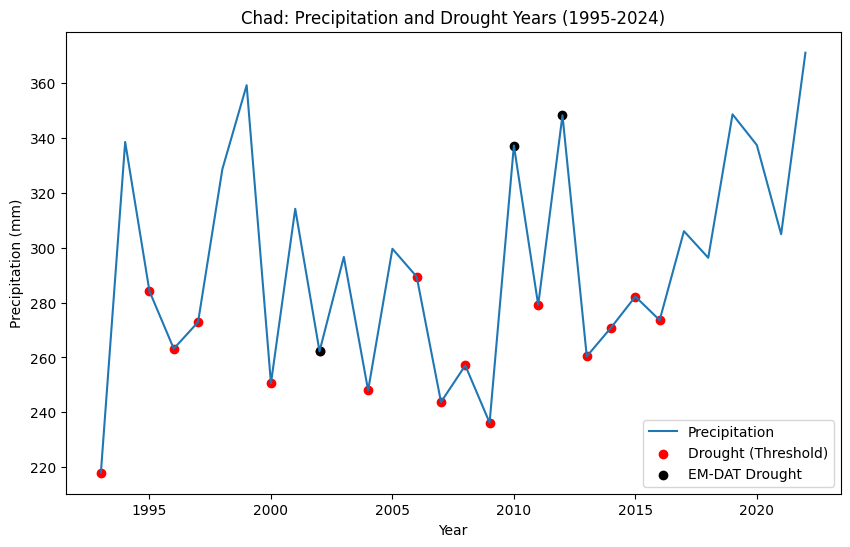

Map(center=[15.282206186229162, 18.65135847264551], controls=(WidgetControl(options=['position', 'transparent_…

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(chad_df['year'], chad_df['precip'], label='Precipitation')
plt.scatter(chad_df[chad_df['drought']]['year'], chad_df[chad_df['drought']]['precip'],
            color='red', label='Drought (Threshold)')
plt.scatter(chad_df[chad_df['emdat_drought']]['year'], chad_df[chad_df['emdat_drought']]['precip'],
            color='black', label='EM-DAT Drought')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Chad: Precipitation and Drought Years (1995-2024)')
plt.legend()
plt.show()

Map = geemap.Map()
masked_sat = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
              .filterDate('2022-06-01', '2022-10-31')  # Switched to 2022 for complete data
              .filterBounds(chad)
              .median()
              .clip(chad))
Map.addLayer(chad, {}, 'Chad Boundary')
Map.addLayer(masked_sat, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, '2022 Satellite')
Map.centerObject(chad, 5)
Map